# AIM
- To validate preprocessing data

Created on: 21 Mar 2022

# Workspace

In [2]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import feather

## custom modules
# import sys  
# sys.path.append('../../scripts')

import import_data
import clean_data
import helper
import report
import plotting

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

# PARAMETERS

In [3]:
WRITE_TO_DISK = True
OUTPUT_DIR = clean_data_dir / "preprocessMar22"

SLEEP_TIME_START = '20:00'
SLEEP_TIME_END = '10:00'

PANDEMIC_CUTOFF   = dt.date(2020, 1, 30) 

## SUBSETTING
SUBSET_START_DATE = None
SUBSET_END_DATE   = None
SUBSET_PID        = None
#  ['0104dfff-4dcd-48ff-b912-51362f098ed0']

# Import

In [11]:
phqs_raw, slps_raw, metadata = import_data.import_data(source_data_dir)

# Preprocessing using method 2 (expanding intervals to timestamps)

create output directory

In [4]:
OUTPUT_DIR.mkdir(exist_ok=True)

clean_slps

In [5]:
with helper.Timer("clean_slps"):
    intervals_all = clean_data.clean_slps(slps_raw)

# [clean_slps]
Elapsed: 5.0 seconds


Drop intervals after COVID

In [6]:
intervals = plotting.subset_intervals(intervals_all, end_date=PANDEMIC_CUTOFF, msg="Drop intervals after pandemic")

# Drop intervals after pandemic
1855957->1844095 rows (Change = -11862) (nrow after = 99.36% of before)


!!!!! EXAMPLE INTERVAL SUBSET

In [7]:
#### Subset by criteria
# intervals = plotting.subset_intervals(intervals_all, start_date=SUBSET_START_DATE, end_date=SUBSET_END_DATE, id=SUBSET_PID, msg="Sample a small testing set")

### Slicing
intervals = intervals_all.head(2)

print(f"Intervals sampled: {intervals.shape[0]}")

Intervals sampled: 2


In [ ]:
with helper.Timer("Binning and normalization"):
    binned = clean_data.bin_by_time(dedupped, freq='1H')
    binned_norm = clean_data.normalize_binned(binned)

In [ ]:
with helper.Timer("Expand to full range of hours"):
    binned_norm['hour'] = binned_norm['t'].dt.hour
    binned_norm['start_date'] = binned_norm['t'].dt.date
    expanded = clean_data.expand_full_hours(binned_norm)

In [ ]:
intervals = plotting.subset_intervals(intervals_all, end_date=PANDEMIC_CUTOFF, msg="Drop intervals after pandemic")

In [ ]:
### EXAMPLE INTERVAL SUBSET
#### Subset by criteria
# intervals = plotting.subset_intervals(intervals_all, start_date=SUBSET_START_DATE, end_date=SUBSET_END_DATE, id=SUBSET_PID, msg="Sample a small testing set")

### Slicing
# FRAC = 0.1
# keep_flag = int(np.floor(intervals_all.shape[0] * FRAC))
# intervals = intervals_all.head(keep_flag)

In [ ]:
### KEEP ALL
intervals = intervals_all

print(f"Intervals sampled: {intervals.shape[0]}")

explode

In [ ]:
with helper.Timer("explode2ts"):
    timeseries = clean_data.explode2ts(intervals)
    report.report_change_in_nrow(intervals, timeseries)

Subset timestamps within a defined interval

In [ ]:
with helper.Timer("Subset timestamps within defined interval"):
    timeseries_subset = clean_data.subset_timeseries_within_interval(timeseries, SLEEP_TIME_START, SLEEP_TIME_END)

Fix overlap

In [ ]:
with helper.Timer("Remove overlapped timestamps and sleep stage labels"):
    dedupped = clean_data.dedup_timeseries(timeseries_subset)
with helper.Timer("Binning and normalization"):
    binned = clean_data.bin_by_time(dedupped, freq='1H')
    binned_norm = clean_data.normalize_binned(binned)
with helper.Timer("Expand to full range of hours"):
    binned_norm['hour'] = binned_norm['t'].dt.hour
    binned_norm['start_date'] = binned_norm['t'].dt.date
    expanded = clean_data.expand_full_hours(binned_norm)
    expanded.drop('t', axis=1, inplace=True)

Binning

In [ ]:
OUTPUT_DIR

In [ ]:
# save
if WRITE_TO_DISK:

    # p = OUTPUT_DIR / 'timeseries.ftr'
    # timeseries.reset_index(drop=True).to_feather(p)
    
    # p = OUTPUT_DIR / 'dedupped.ftr'
    # dedupped.reset_index(drop=True).to_feather(p)

    # p = OUTPUT_DIR / 'binned.ftr'
    # binned.reset_index(drop=True).to_feather(p)
    
    p = OUTPUT_DIR / 'expanded.ftr'
    expanded.reset_index(drop=True).to_feather(p)


Try other frequencies

Section is unfinished because expand_full_hours is not compatiable with other frequencies
This is a loop to loop for any frequencies, to be passed into bin_by_time, for later use


In [ ]:
p = OUTPUT_DIR / 'dedupped.ftr'
dedupped_all = pd.read_feather(p)

In [ ]:

#### NOT RUN ###
if False:
    ### load from disk
    p = OUTPUT_DIR / 'dedupped.ftr'
    dedupped_all = pd.read_feather(p)

    ### sample
    dedupped = dedupped_all.head(10000)

    ### params
    freqs = ['30M']
    WRITE_TO_TASK = False
        
    ### main loop
    for freq in freqs:
        print(f"### {freq=}")
        
        with helper.Timer("Binning and normalization"):
            binned = clean_data.bin_by_time(dedupped, freq=freq)
            binned_norm = clean_data.normalize_binned(binned)

        with helper.Timer("Expand to full range of hours"):
            binned_norm['hour'] = binned_norm['t'].dt.hour
            binned_norm['start_date'] = binned_norm['t'].dt.date
            expanded = clean_data.expand_full_hours(binned_norm)
            expanded.drop("t", axis=1, inplace=True)

        WRITE_TO_DISK = True
        if WRITE_TO_DISK:
            sufffix = 'preprocess' + freq
            OUTPUT_DIR = proj_dir/'data'/'clean'
            OUTPUT_DIR.mkdir(exist_ok=True)
            
            p = OUTPUT_DIR / 'expanded.ftr'
            expanded.reset_index(drop=True).to_feather(p)

Export

In [ ]:
# # save
# if WRITE_TO_DISK:
    
#     p = clean_data_dir / 'slps_timeseries.ftr'
#     timeseries.reset_index(drop=True).to_feather(p)
    
#     p = clean_data_dir / 'slps_dedupped.ftr'
#     dedupped.reset_index(drop=True).to_feather(p)

#     p = clean_data_dir / 'binned.ftr'
#     binned.reset_index(drop=True).to_feather(p)
    
#     p = clean_data_dir / 'expanded.ftr'
#     expanded.reset_index(drop=True).to_feather(p)

Import from saves

In [9]:
SAVE_DIR = proj_dir/"data"/"clean"/"preprocessMar22"

p = SAVE_DIR / 'binned.ftr'
binned = pd.read_feather(p)

p = SAVE_DIR / 'expanded.ftr'
expanded = pd.read_feather(p)

p = SAVE_DIR / 'dedupped.ftr'
dedupped = pd.read_feather(p)

# QC histograms by hour

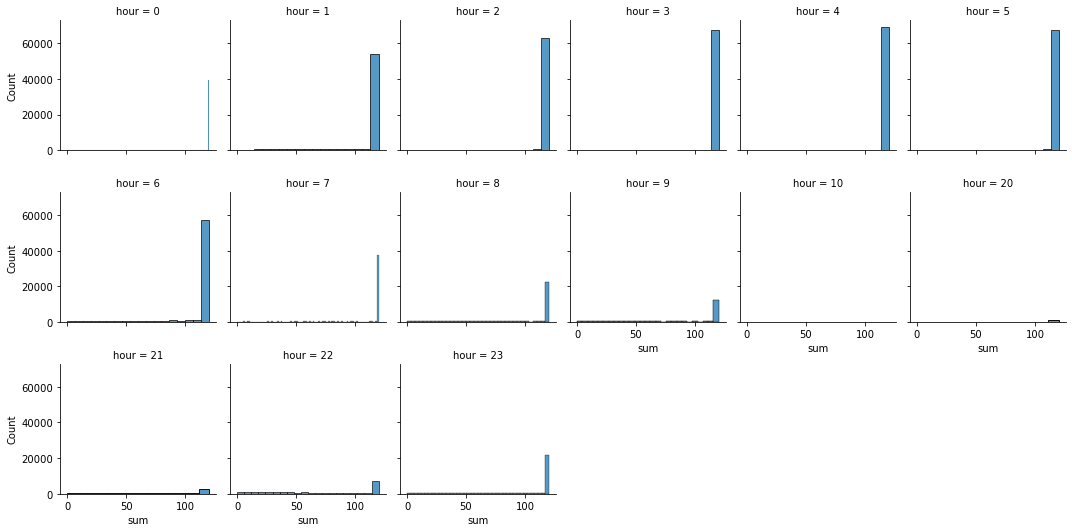

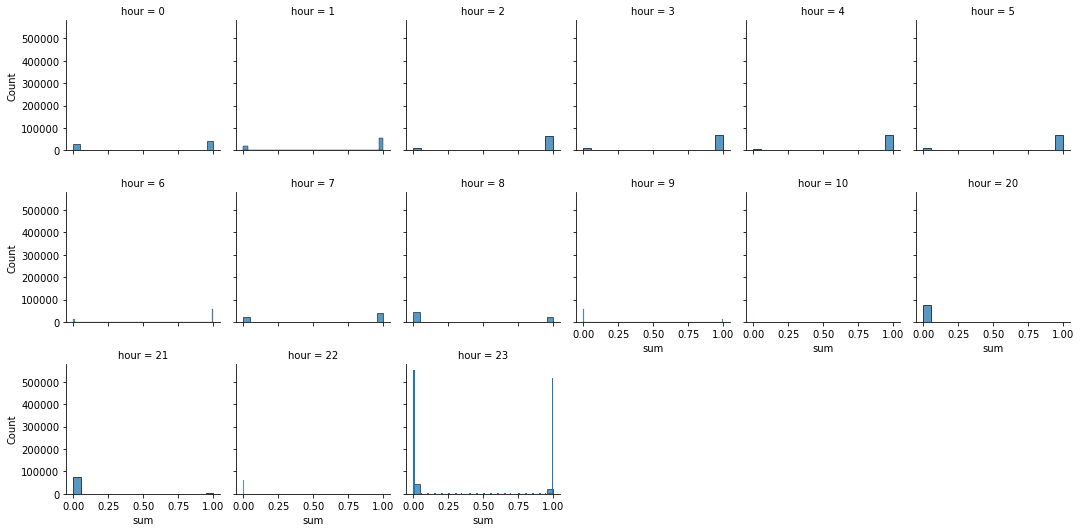

In [6]:
import seaborn as sns


g = sns.FacetGrid(binned, col="hour", height=2.5, col_wrap=6)
g.map(sns.histplot, "sum");
plt.savefig(viz_dir/"binned_hist_by_hour.png")

g = sns.FacetGrid(expanded, col="hour", height=2.5, col_wrap=6)
g.map(sns.histplot, "sum");
plt.savefig(viz_dir/"binned_expanded_hist_by_hour.png")

fig = expanded['sum'].plot.hist(bins=100);


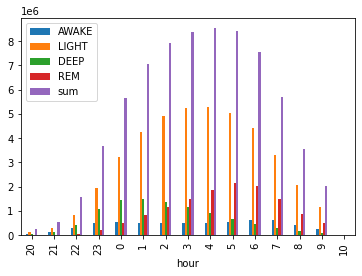

In [8]:
hours = [20,21,22,23,0,1,2,3,4,5,6,7,8,9,10]

hourly_sums = binned.groupby('hour').sum()
hourly_sums = hourly_sums.reindex(hours)
hourly_sums.plot.bar();
plt.savefig(viz_dir/"sleep_stage_duration_by_hour.png")

# Merge

Clean `phqs_raw` to match Haotian's code

In [76]:
target = phqs_raw[['centre', 'pid', 'time', 'phq']].copy()
target.columns = ['centre', 'id', 'time_y', 'phq']

target['time_y'] = pd.to_datetime(target['time_y'])

Beginning of Haotian's code, with modificdations

In [77]:
#Clean target data
"""target["test_date"] = target["time_y"].map(lambda x: x[:10])"""
#! replaced by:
target["test_date"] = target['time_y'].dt.date
target_new = target.loc[:,["id", "test_date", "phq"]]

#Get observation start and end times
"""
id_obs_start = data_tab.groupby('id')['date'].min()
id_obs_end = data_tab.groupby('id')['date'].max()
"""

#! replaced by
expanded.columns = ['id', 'date', 'start_time', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total']
id_obs_start = expanded.groupby('id')['date'].min()
id_obs_end = expanded.groupby('id')['date'].max()

In [78]:
#Adjust the time format
target_new["obs_start"] = pd.to_datetime(target_new.test_date) - pd.Timedelta(days=15)

target_new["obs_start"] = target_new["obs_start"].apply(lambda x:x.strftime('%Y-%m-%d'))

In [79]:
target_new.head(3)

,id,test_date,phq,obs_start
index,,,,
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-02-04,17.0,2019-01-20
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-04,22.0,2019-02-17


In [80]:
#Join the tables
target_new = target_new.merge(id_obs_start, on="id", how="left").merge(id_obs_end, on="id", how="left")

#Filter the target data during the observation period
target_select = target_new.loc[
    (pd.to_datetime(target_new['test_date']) >= pd.to_datetime(target_new['date_x'])) & 
    (pd.to_datetime(target_new['obs_start']) <= pd.to_datetime(target_new['date_y']))
]
#Drop extra columns
target_select = target_select.drop(["date_x", "date_y"], axis = 1)


In [81]:
target_select = clean_data.drop_days_delta(target_select)

# Drop PHQ test results which are within 14 days from previous result
4285->4076 rows (Change = -209) (nrow after = 95.12% of before)


In [82]:
#Link target data and observation data
"""data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])"""
#! replaced by
data_merge = pd.merge(target_select, expanded, how='outer', on=['id'])

In [83]:
data_merge.head(3)

,id,test_date,phq,obs_start,date,start_time,AWAKE,DEEP,LIGHT,REM,total
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,20,0.0,0.0,0.0,0.0,0.0
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,21,0.0,0.0,0.0,0.0,0.0
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,22,0.1,0.0,0.0,0.0,0.1


In [87]:
"""
data_merge_select = data_merge.loc[(pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date)) & (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))]
"""

#! replaced by (formatting)
mask1 = (pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date))
mask2 = (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))
data_merge_select = data_merge.loc[mask1 & mask2]
report.report_change_in_nrow(data_merge, data_merge_select)

735945->735945 rows (Change = 0) (nrow after = 100.0% of before)


In [88]:
# Set new ID: old_ID + PHQ time
#! updated
data_merge_select["id_new"] = data_merge_select.id + "_" + data_merge_select.test_date.astype("string")

In [89]:
# Set new time: date + start_time
#! updated
data_merge_select["time"] = data_merge_select.date.astype("string") + " " + data_merge_select.start_time.astype("string")

In [ ]:
phqs_raw, slps_raw, metadata = import_data.import_data(source_data_dir)

# Merge

In [91]:
phqs_raw.head()

,centre,pid,time,phq,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8
index,,,,,,,,,,,,
0,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21 17:18:28.927000046,16.0,2.0,1.0,3.0,3.0,1.0,2.0,2.0,2.0
1,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-02-04 18:03:59.214999914,17.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0
2,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-04 14:00:03.736000061,22.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0
3,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-18 19:34:10.964999914,19.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0
4,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-04-01 11:04:21.759999990,14.0,2.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0


In [92]:
#Clean target data
"""target["test_date"] = target["time_y"].map(lambda x: x[:10])"""
#! replaced by:
target["test_date"] = target['time_y'].dt.date
target_new = target.loc[:,["id", "test_date", "phq"]]

#Get observation start and end times
"""
id_obs_start = data_tab.groupby('id')['date'].min()
id_obs_end = data_tab.groupby('id')['date'].max()
"""

#! replaced by
expanded.columns = ['id', 'date', 'start_time', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total']
id_obs_start = expanded.groupby('id')['date'].min()
id_obs_end = expanded.groupby('id')['date'].max()

In [93]:
#Adjust the time format
target_new["obs_start"] = pd.to_datetime(target_new.test_date) - pd.Timedelta(days=15)
target_new["obs_start"] = target_new["obs_start"].apply(lambda x:x.strftime('%Y-%m-%d'))

In [ ]:
target_new

,id,test_date,phq,obs_start
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-02-04,17.0,2019-01-20
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-04,22.0,2019-02-17
3,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-18,19.0,2019-03-03
4,bf3defd7-2a52-4557-8202-9d887957e109,2019-04-01,14.0,2019-03-17
...,...,...,...,...
26740932,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-11-06,19.0,2019-10-22
26740933,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-11-20,13.0,2019-11-05
26740934,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-12-04,18.0,2019-11-19
26740935,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-12-18,21.0,2019-12-03


In [ ]:
#Join the tables
target_new = target_new.merge(id_obs_start, on="id", how="left").merge(id_obs_end, on="id", how="left")

#Filter the target data during the observation period
target_select = target_new.loc[
    (pd.to_datetime(target_new['test_date']) >= pd.to_datetime(target_new['date_x'])) & 
    (pd.to_datetime(target_new['obs_start']) <= pd.to_datetime(target_new['date_y']))
]
#Drop extra columns
target_select = target_select.drop(["date_x", "date_y"], axis = 1)


In [ ]:
target_select = clean_data.drop_days_delta(target_select)

# Drop PHQ records which is <14 days from previous:
4283->4074 rows (Change:-209, 95.12% of original)


In [ ]:
#Link target data and observation data
"""data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])"""
#! replaced by
data_merge = pd.merge(target_select, expanded, how='outer', on=['id'])

In [ ]:
data_merge.head(3)

,id,test_date,phq,obs_start,date,start_time,AWAKE,DEEP,LIGHT,REM,total
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,20,0.0,0.0,0.0,0.0,0.0
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,21,0.0,0.0,0.0,0.0,0.0
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,22,0.1,0.0,0.0,0.0,0.1


In [90]:
"""
data_merge_select = data_merge.loc[(pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date)) & (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))]
"""

#! replaced by (formatting)
mask1 = (pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date))
mask2 = (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))
data_merge_select = data_merge.loc[mask1 & mask2]
report.report_change_in_nrow(data_merge, data_merge_select)

735945->735945 rows (Change = 0) (nrow after = 100.0% of before)


In [ ]:
# Set new ID: old_ID + PHQ time
#! updated
data_merge_select["id_new"] = data_merge_select.id + "_" + data_merge_select.test_date.astype("string")

In [ ]:
# Set new time: date + start_time
#! updated
data_merge_select["time"] = data_merge_select.date.astype("string") + " " + data_merge_select.start_time.astype("string")

In [ ]:
data_merge_select = data_merge_select.drop(["test_date", "obs_start", "start_time"], axis = 1)

In [ ]:
show = data_merge_select.head(1000)

In [ ]:
p1 = clean_data_dir/'data_merge.csv'
p2 = clean_data_dir/'data_merge.ftr'
data_merge.to_csv(p1,index=0)
data_merge.reset_index().to_feather(p2)

In [ ]:
print(expanded.shape, data_merge.shape)


(1171860, 8) (735555, 10)


In [ ]:
data_merge.columns

Index(['id', 'phq', 'date', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total', 'id_new',
       'time'],
      dtype='object')

In [ ]:
print(f"""
Shape = {data_merge.shape},
{data_merge["id']}
"""
)



Shape = (735555, 10),




In [ ]:
data_merge = data_merge.drop(["test_date", "obs_start", "start_time"], axis = 1)

In [56]:
show = data_merge.head(1000)

In [61]:
p1 = OUTPUT_DIR /'data_merge.csv'
p2 = OUTPUT_DIR /'data_merge.ftr'
data_merge.to_csv(p1,index=0)
data_merge.reset_index().to_feather(p2)

In [62]:
print(expanded.shape, data_merge.shape)
# Old:    (1171860, 8) (735555, 10)
# Mar 22: (1211205, 8) (774720, 10)

(1211205, 8) (774720, 10)


# Merge using routine

In [94]:
data_merge2 = clean_data.merge_slp_phq(expanded, phqs_raw)

# Drop PHQ test results which are within 14 days from previous result
4285->4076 rows (Change = -209) (nrow after = 95.12% of before)
15886680->735945 rows (Change = -15150735) (nrow after = 4.63% of before)


In [108]:
p2 = OUTPUT_DIR / 'data_merge2.ftr'
data_merge2.reset_index().to_feather(p2)